In [1]:
import sys
sys.path.append("../")
from ploting import CandlePlot
import pandas as pd
from technicals.patterns import apply_patterns
import plotly.graph_objects as go

In [2]:
df= pd.read_pickle("../data/EUR_USD_H1.pkl")

In [3]:
df_an=df[["time","mid_c","mid_o","mid_h","mid_l"]].copy()

In [4]:
df_an.tail()

time    mid_c    mid_o    mid_h    mid_l
35653 2021-12-30 19:00:00+00:00  1.13274  1.13058  1.13298  1.13043
35654 2021-12-30 20:00:00+00:00  1.13193  1.13272  1.13304  1.13185
35655 2021-12-30 21:00:00+00:00  1.13258  1.13195  1.13276  1.13194
35656 2021-12-30 22:00:00+00:00  1.13230  1.13252  1.13264  1.13222
35657 2021-12-30 23:00:00+00:00  1.13224  1.13227  1.13258  1.13190

In [5]:
# direction= df_an.mid_c-df_an.mid_o
# body_size=abs(direction)
# direction=[1 if x>=0 else -1 for  x in direction]
# full_range=df_an.mid_h-df_an.mid_l
# body_percentage=(body_size/full_range)*100
# body_lower= df_an[["mid_c","mid_o"]].min(axis=1)
# body_upper= df_an[["mid_c","mid_o"]].max(axis=1)
# body_bottom_perc= ((body_lower-df_an.mid_l)/full_range)*100
# body_upper_perc= ((df_an.mid_h-body_upper)/full_range)*100

In [6]:
# df_an['body_lower']=body_lower
# df_an['body_upper']=body_upper
# df_an['body_bottom_perc']=body_bottom_perc
# df_an['body_upper_perc']=body_upper_perc
# df_an['body_lower']=body_lower
# df_an['body_percentage']=body_percentage
df_an=apply_patterns(df_an)
df_an.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35658 entries, 0 to 35657
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype                  
---  ------            --------------  -----                  
 0   time              35658 non-null  datetime64[ns, tzutc()]
 1   mid_c             35658 non-null  float64                
 2   mid_o             35658 non-null  float64                
 3   mid_h             35658 non-null  float64                
 4   mid_l             35658 non-null  float64                
 5   body_lower        35658 non-null  float64                
 6   body_upper        35658 non-null  float64                
 7   body_bottom_perc  35653 non-null  float64                
 8   body_upper_perc   35653 non-null  float64                
 9   body_perc         35653 non-null  float64                
 10  direction         35658 non-null  int64                  
 11  body_size         35658 non-null  float64                
 12  low_

In [7]:
HANGING_MAN_BODY=15.0
HANGING_MAN_HEIGHT=75.0
SHOOTING_STAR_HEIGHT=25.0
SPINNING_TOP_MIN=40.0
SPINNING_TOP_MAX=60.0
MARUBOZU=98.0
ENGULFING_FACTOR=1.8
TWEEZER_BODY=15.0
TWEEZER_HL= 0.01
TWEEZER_TOP_BODY=40.0
TWEEZER_BOTTOM_BODY=60.0
MORNING_STAR_PREV2_BODY=90.0
MORNING_STAR_PREV_BODY=10.0
def apply_hanging_man(row):
    if row.body_bottom_perc >HANGING_MAN_HEIGHT:
        if row.body_perc < HANGING_MAN_BODY:
            return True
    return False
    
def apply_shooting_star(row):
    if row.body_upper_perc >SHOOTING_STAR_HEIGHT:
        if row.body_perc< HANGING_MAN_BODY:
            return True
    return False

def apply_spinning_top(row):
    if row.body_upper_perc <SPINNING_TOP_MAX:
        if row.body_bottom_perc >SPINNING_TOP_MIN:
             if row.body_perc<HANGING_MAN_BODY:
                 return True
    return False

apply_marubozu=lambda x:x.body_perc>MARUBOZU
    
def apply_engulfing(row):
    if row.direction!=row.direction_prev:
        if row.body_size>row.body_size_prev*ENGULFING_FACTOR:
            return True
        return False

def apply_tweezer_top(row):
    if abs(row.body_size_change)<TWEEZER_BODY:
        if row.direction==-1 and row.direction!= row.direction_prev:
            if abs(row.low_change)<TWEEZER_HL and abs(row.high_change)<TWEEZER_HL :
                if row.body_upper_perc<TWEEZER_TOP_BODY:
                    return True
    return False


def apply_tweezer_bottom(row):
    if abs(row.body_size_change)<TWEEZER_BODY:
        if row.direction==1 and row.direction!= row.direction_prev:
            if abs(row.low_change)<TWEEZER_HL and abs(row.high_change)<TWEEZER_HL :
                if row.body_bottom_perc>TWEEZER_BOTTOM_BODY:
                    return True
    return False

def apply_morning_star(row,direction=1):
    if row.body_perc_prev_2>MORNING_STAR_PREV2_BODY:
        if row.body_perc_prev <MORNING_STAR_PREV_BODY:
            if row.direction == direction and row.direction_prev_2 != direction:
                if direction ==1:
                    if row.mid_c> row.mid_point_prev_2:
                        return True
                else:
                    if row.mid_c< row.mid_point_prev_2:
                        return True
    return False
        

In [17]:
df_an['body_size_prev']=df_an.body_size.shift(1)
df_an['direction_prev']=df_an.direction.shift(1)
df_an['direction_prev_2']=df_an.direction.shift(2)
df_an['body_perc_prev']=df_an.body_perc.shift(1)
df_an['body_perc_prev_2']=df_an.body_perc.shift(2)
df_an['HANGING_MAN']=df_an.apply(apply_hanging_man,axis=1)
df_an['SHOOTING_STAR']=df_an.apply(apply_shooting_star,axis=1)
df_an['SPINNING_TOP']=df_an.apply(apply_spinning_top,axis=1)
df_an['MARUBOZU']=df_an.apply(apply_marubozu,axis=1)
df_an['ENGULFING']=df_an.apply(apply_engulfing,axis=1)
df_an['TWEEZER_TOP']=df_an.apply(apply_tweezer_top,axis=1)
df_an['TWEEZER_BOTTOM']=df_an.apply(apply_tweezer_bottom,axis=1)
df_an['MORNING_STAR']=df_an.apply(apply_morning_star, direction=-1,axis=1)
df_an['EVENING_STAR']=df_an.apply(apply_morning_star,axis=1)


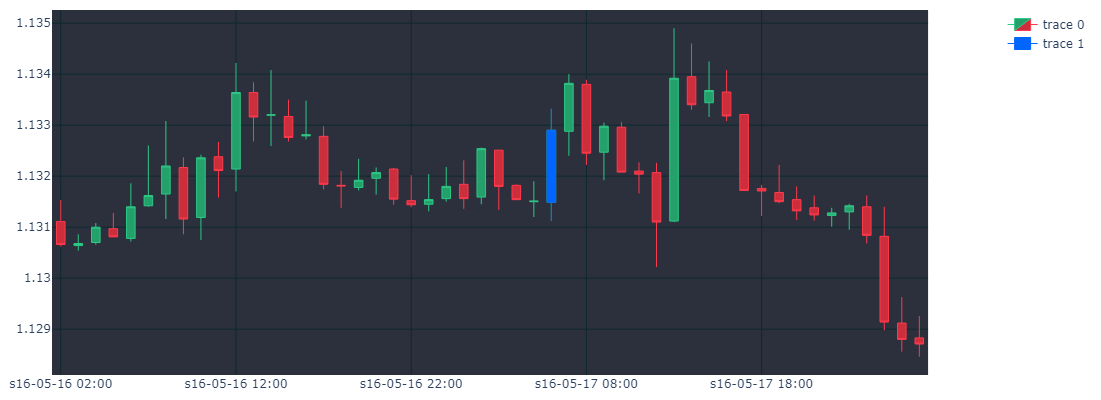

In [23]:

MARKER="#0066FF"
dfp=df_an.iloc[650:700]
cp=CandlePlot(dfp,candles=True)
df_temp=cp.df_plot[cp.df_plot.EVENING_STAR==True]
cp.fig.add_trace(go.Candlestick(
                x=df_temp.sTime,
                open=df_temp.mid_o,
                close=df_temp.mid_c,
                high=df_temp.mid_h,
                low=df_temp.mid_l,

                line=dict(width=1), opacity=1,
                increasing_fillcolor=MARKER,
                decreasing_fillcolor=MARKER,
                increasing_line_color=MARKER,
                decreasing_line_color=MARKER,

        ))
cp.show_plot()


In [21]:
df_an[df_an["EVENING_STAR"]==True]

time    mid_c    mid_o    mid_h    mid_l  \
678   2016-05-17 06:00:00+00:00  1.13290  1.13149  1.13332  1.13112   
3393  2016-10-21 09:00:00+00:00  1.09016  1.08807  1.09040  1.08784   
7868  2017-07-12 22:00:00+00:00  1.14160  1.14128  1.14182  1.14122   
9090  2017-09-21 20:00:00+00:00  1.19420  1.19317  1.19426  1.19317   
9944  2017-11-10 09:00:00+00:00  1.16604  1.16344  1.16622  1.16287   
10500 2017-12-13 13:00:00+00:00  1.17576  1.17399  1.17712  1.17295   
11436 2018-02-08 13:00:00+00:00  1.22754  1.22368  1.22767  1.22340   
11815 2018-03-02 08:00:00+00:00  1.22744  1.22632  1.22786  1.22548   
12286 2018-03-29 22:00:00+00:00  1.23042  1.23014  1.23062  1.23000   
13294 2018-05-28 22:00:00+00:00  1.16265  1.16248  1.16283  1.16228   
13963 2018-07-05 19:00:00+00:00  1.16929  1.16804  1.16934  1.16795   
17935 2019-02-26 08:00:00+00:00  1.13550  1.13500  1.13590  1.13458   
19273 2019-05-15 01:00:00+00:00  1.12073  1.12039  1.12082  1.12030   
19558 2019-05-30 22:00:00+00:00  1.11332  1.11291  1.11332  1.11291   
20760 2019-08-09 00:00:00+00:00  1.11928  1.11865  1.11946  1.11852   
21290 2019-09-10 02:00:00+00:00  1.10456  1.10428  1.10468  1.10405   
21935 2019-10-16 22:00:00+00:00  1.10749  1.10731  1.10764  1.10731   
22523 2019-11-20 13:00:00+00:00  1.10640  1.10568  1.10640  1.10532   
24239 2020-03-03 02:00:00+00:00  1.11406  1.11321  1.11463  1.11288   
24699 2020-03-30 05:00:00+00:00  1.11008  1.10814  1.11024  1.10704   
29618 2021-01-13 06:00:00+00:00  1.22140  1.22091  1.22174  1.22080   
33394 2021-08-20 13:00:00+00:00  1.16796  1.16683  1.16854  1.16640   
33610 2021-09-02 13:00:00+00:00  1.18588  1.18472  1.18626  1.18464   

       body_lower  body_upper  body_bottom_perc  body_upper_perc   body_perc  \
678       1.13149     1.13290         16.818182        19.090909   64.090909   
3393      1.08807     1.09016          8.984375         9.375000   81.640625   
7868      1.14128     1.14160         10.000000        36.666667   53.333333   
9090      1.19317     1.19420          0.000000         5.504587   94.495413   
9944      1.16344     1.16604         17.014925         5.373134   77.611940   
10500     1.17399     1.17576         24.940048        32.613909   42.446043   
11436     1.22368     1.22754          6.557377         3.044496   90.398126   
11815     1.22632     1.22744         35.294118        17.647059   47.058824   
12286     1.23014     1.23042         22.580645        32.258065   45.161290   
13294     1.16248     1.16265         36.363636        32.727273   30.909091   
13963     1.16804     1.16929          6.474820         3.597122   89.928058   
17935     1.13500     1.13550         31.818182        30.303030   37.878788   
19273     1.12039     1.12073         17.307692        17.307692   65.384615   
19558     1.11291     1.11332          0.000000         0.000000  100.000000   
20760     1.11865     1.11928         13.829787        19.148936   67.021277   
21290     1.10428     1.10456         36.507937        19.047619   44.444444   
21935     1.10731     1.10749          0.000000        45.454545   54.545455   
22523     1.10568     1.10640         33.333333         0.000000   66.666667   
24239     1.11321     1.11406         18.857143        32.571429   48.571429   
24699     1.10814     1.11008         34.375000         5.000000   60.625000   
29618     1.22091     1.22140         11.702128        36.170213   52.127660   
33394     1.16683     1.16796         20.093458        27.102804   52.803738   
33610     1.18472     1.18588          4.938272        23.456790   71.604938   

       ...  body_perc_prev_2  HANGING_MAN  SHOOTING_STAR  SPINNING_TOP  \
678    ...         90.322581        False          False         False   
3393   ...         97.037037        False          False         False   
7868   ...         91.208791        False          False         False   
9090   ...         90.384615        False          False         False   
9944   ...         96.250000   